In [70]:
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import pickle

In [71]:
try:
    import jellyfish  # Last time I checked this module was the fastest kid on the block, however 2x slower than a simple Cython function
    def fast_hamming_dist(s1, s2):
        if s1 == s2:
            return 0
        else:
            return jellyfish.hamming_distance(s1, s2)
except:
    print('Couldn\'t find the python module "jellyfish" which is used for fast string comparison. Falling back to pure python function.')
    fast_hamming_dist = hamming_distance

In [72]:
### Instead of T cell help just using affinity to antigen as a proxy:

# [B1:A] = 1/(1+Kd_1/[A])
# [B2:A] = 1/(1+Kd_2/[A])
# .
# .                              =   Bi:A(A)  <-- B1:A, B2:A, ..., Bn:A as a function of A
# .
# [Bn:A] = 1/(1+Kd_n/A)

# array(Bn:A)(A) = array(1)/(array(1)+array(Kd_n)/A*)


# Fullfilling:
# [A_total] = [A] + sum(Bi:A(A))  <--- law of mass conservation

In [73]:
def return_BnA(Kd_n, A):
    BnA = 1/(1+Kd_n/A)
    return(BnA)

In [74]:
def return_objective_A(Kd_n, A_total):
#    A_total = 1  # A_total is just a relative number, and a multiplicative factor will change its magnitude
    obj = lambda A: (A_total - (A + np.sum(1/(1+Kd_n/A))))**2
    return(obj)

In [75]:
def calc_binding_time(Kd_n, A_total):
    obj = return_objective_A(Kd_n, A_total)
    # Different minimizers have been tested and 'L-BFGS-B' was significant faster than anything else:
    obj_min = minimize(obj, A_total, bounds=[[0, A_total]], method='L-BFGS-B', tol=1e-20)
    BnA = return_BnA(Kd_n, obj_min.x[0])
    assert(BnA.sum()+obj_min.x[0]-A_total < A_total/100)
    #print(obj_min.x[0])
    return(BnA)

In [76]:
def calc_Kd(seqAA, targets, max_affs, hds):
    Kd = min([a + fast_hamming_dist(seqAA, t) * hds for t, a in zip(targets, max_affs)])
    return(Kd)

In [77]:
def T_BA(BA, p):
    # We keep alpha to enable the possibility
    # that there is a minimum lambda_
    alpha, beta, Q = p
    lambda_ = alpha + (2 - alpha) / (1 + Q*np.exp(-beta*BA))
    return(lambda_)

In [78]:
# GPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLEYMGYISFSGGTYYNPSLKSRISITRDTSKNQYHLQLNSVTTEDTATYYC
# Just adding something random:
targets = ['GPSLVKPSQTLSLTC',
           'ISFSGGTYYNPSLKS',
           'SRISITRDTSKNTED']
AAseqs = ['GHSLVLPSTTLHLTN',
          'IGFSGGTYFNPSLNN',
          'SNITITRDSSKRTEE',
          'GHKLVLPSFTLHLTN',
          'IGFTGGTYFNPFLNN',
          'SNITNTRRSSKRTEE',
          'GHSLVLPETTLHLTN',
          'AGFSGGTYFNPSLNN',
          'SNITITRDSAKRTEE',
          'GHCLVLPSTTLHATN',
          'IGFSCGTYFNPSLNN',
          'SNITITRGSSKRTEE']
max_affs = [10**(-6), 5*10**(-7), 10**(-8)]
hds = 10**(-6)
carry_cap = 9

In [79]:
max_affs

[1e-06, 5e-07, 1e-08]

In [80]:
# Parameters for the generalized logistic function to transform :
Tparams = [-0.002, 13.8, 996]
carrying_population  = 9
A_total  = carrying_population/2
Kd_n = np.array([calc_Kd(seqAA, targets, max_affs, hds) for seqAA in AAseqs])
BnA = calc_binding_time(Kd_n, A_total)
T_BA(BnA, Tparams)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


array([ 0.30995913,  0.64937172,  0.50055941,  0.20141412,  0.24808862,
        0.20060519,  0.20141412,  0.39259503,  0.30853939,  0.13832847,
        0.39259503,  0.30853939])

In [81]:
def lambda_selection(AAseq, targets, max_affs, hds, carry_cap):
    # Parameters for the generalized logistic function to transform B:A
    # into a lambda parameter to the progeny distribution:
    Tparams = [-0.002, 13.8, 996]
    A_total  = carry_cap/2
    Kd_n = np.array([calc_Kd(AAseq, targets, max_affs, hds) for seqAA in AAseqs])
    BnA = calc_binding_time(Kd_n, A_total)
    lambda_ = T_BA(BnA, Tparams)
    
    return(lambda_)

In [82]:
lambda_selection(AAseqs[0], targets, max_affs, hds, carry_cap)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


array([ 0.29888127,  0.29888127,  0.29888127,  0.29888127,  0.29888127,
        0.29888127,  0.29888127,  0.29888127,  0.29888127,  0.29888127,
        0.29888127,  0.29888127])

In [83]:
def find_Lp(f_full, U):
    assert(U > 1)
    def T_BA(BA, p):
        # We keep alpha to enable the possibility
        # that there is a minimum lambda_
        alpha, beta, Q = p
        lambda_ = alpha + (2 - alpha) / (1 + Q*np.exp(-beta*BA))
        return(lambda_)

    def solve_T_BA(p, f_full, U):
        epsilon = 1/1000
        C1 = (T_BA(0, p) - 0)**2
        C2 = (T_BA(f_full/U, p) - 1)**2
        C3 = (T_BA(1*f_full, p) - (2 - 2*epsilon))**2
        return(C1, C2, C3)

    def solve_T_BA_low_epsilon(p, f_full, U):
        epsilon = 1/1000
        C1 = (T_BA(0, p) - 0)**2
        C2 = (T_BA(f_full/U, p) - 1)**2
        C3 = (T_BA(1*f_full, p) - (2 - 2*epsilon))**2 * ((2 - T_BA(1*f_full, p)) < 2*epsilon)
        return(C1, C2, C3)

    # Some funny "FloatingPointError" errors are not affecting results so ignore them:
    old_settings = np.seterr(all='ignore')  # Keep old settings
    np.seterr(over='ignore')
    try:
        def obj_T_A(p): return(solve_T_BA(p, f_full, U))
        p = fsolve(obj_T_A, (0, 10e-5, 1), xtol=1e-20, maxfev=1000)
        assert(sum(solve_T_BA(p, f_full, U)) < f_full * 1/1000)
    except:
        print('The U parameter is large and therefore the epsilon parameter has to be adjusted to find a valid solution.')
        def obj_T_A(p): return(solve_T_BA_low_epsilon(p, f_full, U))
        p = fsolve(obj_T_A, (0, 10e-5, 1), xtol=1e-20, maxfev=1000)
        assert(sum(solve_T_BA(p, f_full, U)) < f_full * 1/1000)
    np.seterr(**old_settings)  # Reset to default
    return(p)

In [102]:
Ul = [1.2, 1.5, 1.8, 2, 3, 5, 10]
f_full = 1
for U in Ul[::-1]:
    p = find_Lp(f_full, U)
    print(p)



The U parameter is large and therefore the epsilon parameter has to be adjusted to find a valid solution.
[-3.00933283  9.79965855  0.66471476]
[-0.59912445  8.374447    3.33820462]
[ -0.0687401   10.31115043  29.09509673]
[ -2.00797632e-03   1.38115153e+01   9.96004200e+02]
[ -3.56308142e-04   1.55397980e+01   5.61313610e+03]
[  8.29023539e-04   1.62497766e+01   5.06869691e+04]
[ -2.62876632e-03   3.21160977e+01   4.16632517e+11]


/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The U parameter is large and therefore the epsilon parameter has to be adjusted to find a valid solution.


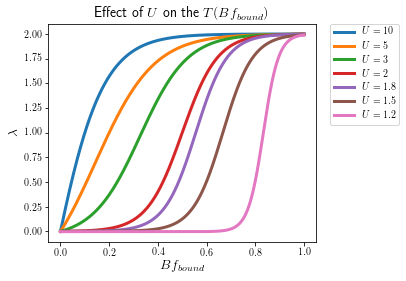

In [108]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
fig = plt.figure()
ax = plt.subplot(111)

Ul = [1.2, 1.5, 1.8, 2, 3, 5, 10]
f_full = 1
for U in Ul[::-1]:
    p = find_Lp(f_full, U)
    t = np.arange(0, f_full, 0.0001)
    s = T_BA(t, p)
    ax.plot(t, s, lw=3, label=r'$U = {}$'.format(U))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.ylabel(r'$\lambda$', fontsize=14)
plt.xlabel(r'$Bf_{bound}$', fontsize=14)
plt.title(r'Effect of $U$ on the $T(Bf_{bound})$', fontsize=14)
#fig.savefig('T_fBbound_U.eps')
fig.savefig('T_Bfbound_U.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


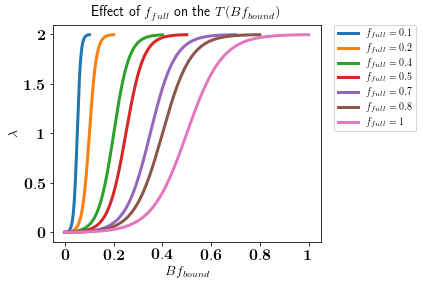

In [103]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
fig = plt.figure()
ax = plt.subplot(111)

U = 2
f_full_l = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 1]
#f_full_l = [1]
for f_full in f_full_l:
    p = find_Lp(f_full, U)
    t = np.arange(0, f_full, 0.0001)
    s = T_BA(t, p)
    ax.plot(t, s, lw=3, label=r'$f_{{full}} = {}$'.format(f_full))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.tick_params(axis='both', which='both', labelsize=16)

tick_locs = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs])

tick_locs = [0, 0.5, 1, 1.5, 2]
plt.yticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs]) 



plt.ylabel(r'$\lambda$', fontsize=14)
plt.xlabel(r'$Bf_{bound}$', fontsize=14)
plt.title(r'Effect of $f_{full}$ on the $T(Bf_{bound})$', fontsize=14)
fig.savefig('T_Bfbound_f_full.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


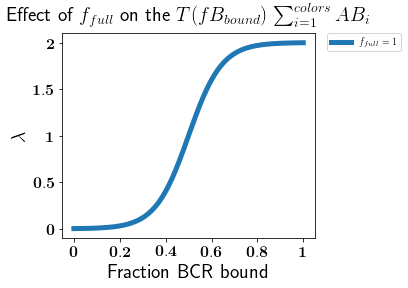

In [68]:
####
#### For the cartoon figure of the flow of the model
####
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
fig = plt.figure()
ax = plt.subplot(111)

U = 2
#f_full_l = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 1]
f_full_l = [1]
for f_full in f_full_l:
    p = find_Lp(f_full, U)
    t = np.arange(0, f_full, 0.0001)
    s = T_BA(t, p)
    ax.plot(t, s, lw=5, label=r'$f_{{full}} = {}$'.format(f_full))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Shrink current axis by 20%
box = ax.get_position()
box.y0 = 0.17
box.x0 = 0.17
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height*0.9])
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.tick_params(axis='both', which='both', labelsize=16)

tick_locs = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs])

tick_locs = [0, 0.5, 1, 1.5, 2]
plt.yticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs]) 



plt.ylabel(r'$\lambda$', fontsize=20)
plt.xlabel(r'Fraction BCR bound', fontsize=20)
#plt.xlabel(r'$fB_{bound}$', fontsize=20)
#plt.title(r'Effect of $f_{full}$ on the $T(fB_{bound})$', fontsize=20)
plt.title(r'Effect of $f_{full}$ on the $T(fB_{bound})$ $\sum_{i=1}^{colors} AB_i$', fontsize=20)
#fig.savefig('T_fBbound_f_full.eps')
fig.savefig('T_fBbound_f_full.pdf')
plt.show()

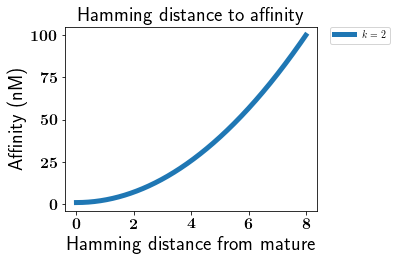

In [69]:
import matplotlib.pyplot as plt
from matplotlib import rc

font = {'weight' : 'bold'}
rc('font', **font)  # pass in the font dict as kwargs
# hfont = {'fontname':'Helvetica'}
hfont = {}

rc('text', usetex=True)
fig = plt.figure()
ax = plt.subplot(111)

m = 1
n = 100
dm = 8
def Af(d, dm, m, n, k): return(m + d**k * (n - m)/dm**k)
#ks = [0.1, 0.2, 0.4, 0.7, 1, 2, 5, 10]
ks = [2]
for i in ks:
    t = np.arange(0, dm, 0.01)
    s = Af(t, dm, m, n, i)
    ax.plot(t, s, lw=5, label=r'$k = {}$'.format(i))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


# Shrink current axis by 20%
box = ax.get_position()
box.y0 = 0.17
box.x0 = 0.17
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height*0.9])

plt.tick_params(axis='both', which='both', labelsize=16)

tick_locs = [0, 2, 4, 6, 8]
plt.xticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs])

tick_locs = [0, 25, 50, 75, 100]
plt.yticks(tick_locs, [r"$\mathbf{%s}$" % x for x in tick_locs]) 

plt.ylabel(r'Affinity (nM)', fontsize=20,**hfont)
plt.xlabel(r'Hamming distance from mature', fontsize=20,**hfont)
plt.title(r'Hamming distance to affinity', fontsize=20,**hfont)
fig.savefig('hd2affy.pdf')
plt.show()

In [17]:
def A_total_fun(A, B_total, Kd_n): return(A + np.sum(B_total/(1+Kd_n/A)))

def C_A(A, A_total, f_full): return(2 * (A_total - A) / f_full)

def A_obj(carry_cap, B_total, f_full, Kd_n):
    def objA(A): return((carry_cap - C_A(A, A_total_fun(A, B_total, Kd_n), f_full))**2)
    return(objA)

In [18]:
mature_affy = 0.1
carry_cap = 1000
B_total = 1
f_full = B_total
Kd_n = np.array([mature_affy] * carry_cap)

In [19]:
def find_A_total(carry_cap, B_total, f_full, Kd_n):
    obj = A_obj(carry_cap, B_total, f_full, Kd_n)
    obj_min = minimize(obj, 1e-20, bounds=[[1e-20, carry_cap]], method='L-BFGS-B', tol=1e-20)
    A = obj_min.x[0]
    A_total = A_total_fun(A, B_total, Kd_n)
    assert(C_A(A, A_total, f_full) > carry_cap * 99/100)
    return(A_total)

In [20]:
find_A_total(carry_cap, B_total, f_full, Kd_n)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


500.09998749500193

In [21]:
f = '../selection.runstats.p'  # The runstats file from a simulation with selection
with open(f, 'rb') as fh:
    runstats = pickle.load(fh, encoding='bytes')

FileNotFoundError: [Errno 2] No such file or directory: '../selection.runstats.p'

In [784]:
pop_size = np.array([sum(r[0]) for r in runstats])

In [758]:
def make_bounds(runstats):
    all_counts = runstats[0][0].copy()
    for l in runstats:
        all_counts += l[0]
    i = None
    ii = None
    for j, c in enumerate(all_counts):
        if i is None and c > 0:
            i = j
        elif c > 0:
            ii = j
    return(i, ii)

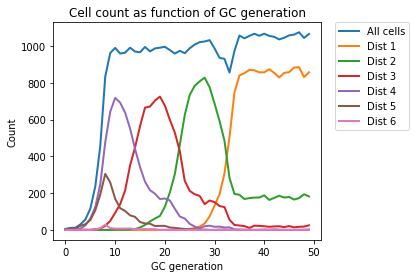

In [789]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
#fig_size = [0,0]
#fig_size[0] = 12*1.6
#fig_size[1] = 9*1.3
#plt.rcParams["figure.figsize"] = fig_size
t = np.array(list(range(len(pz))))
ax.plot(t, pop_size, lw=2, label='All cells')

bounds = make_bounds(runstats)
for k in list(range(*bounds)):
    ax.plot(t, np.array([r[0][k] for r in runstats]), lw=2, label='Dist {}'.format(k))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.ylabel('Count')
plt.xlabel('GC generation')
plt.title('Cell count as function of GC generation')
fig.savefig('test.svg')

In [768]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [767]:
fig = plt.figure()
fig.savefig('test.png')

In [765]:
%%bash
ls -rtl

total 1224
-rw-r--r--@ 1 krdav  staff  203940 Feb 16 14:46 gctree_notebook.ipynb
-rw-r--r--@ 1 krdav  staff   32352 Mar 16 17:28 Tcell_help_solver.ipynb
-rw-r--r--@ 1 krdav  staff  381000 Mar 21 12:05 affinity_solver.ipynb
-rw-r--r--@ 1 krdav  staff     609 Mar 21 12:06 test.svg


In [694]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [695]:
def plot_LineSegements(x,
                       ys,
                       ylim=[0.0,1.0], 
                       label_str='',
                       linewidth=2.0,
                       linestyle='solid',
                       cm='copper',
                       outOS=None):

    fig_size = [0,0]
    fig_size[0] = 12*1.3
    fig_size[1] = 9*1.3
    plt.rcParams["figure.figsize"] = fig_size
    # set the plot limits, they will not autoscale
    ax = plt.axes()
    ax.set_xlim((x.min(),x.max()))
    ax.set_ylim(ylim)

    # colors is sequence of rgba tuples
    # linestyle is a string or dash tuple. Legal string values are
    #          solid|dashed|dashdot|dotted.  The dash tuple is (offset, onoffseq)
    #          where onoffseq is an even length tuple of on and off ink in points.
    #          If linestyle is omitted, 'solid' is used
    # See matplotlib.collections.LineCollection for more information
    line_segments = LineCollection([list(zip(x, y)) for y in ys], # Make a sequence of x,y pairs
                                    linewidths    = linewidth,
                                    linestyles = linestyle,
                                    cmap=plt.get_cmap(cm))
    line_segments.set_array(np.arange(np.array(ys).shape[0]))
    ax.add_collection(line_segments)
    fig = plt.gcf()
    axcb = fig.colorbar(line_segments)
    axcb.set_label(label_str)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.set_title('Distribution of smallest hamming distances at different generations')
    plt.ylabel('Count')
    plt.xlabel('Hamming distance')
    ax.set_axisbelow(True)
    plt.sci(line_segments) # This allows interactive changing of the colormap.
    if outOS == None:
        plt.show()
    else:
        plt.savefig(outOS)
        plt.clf()

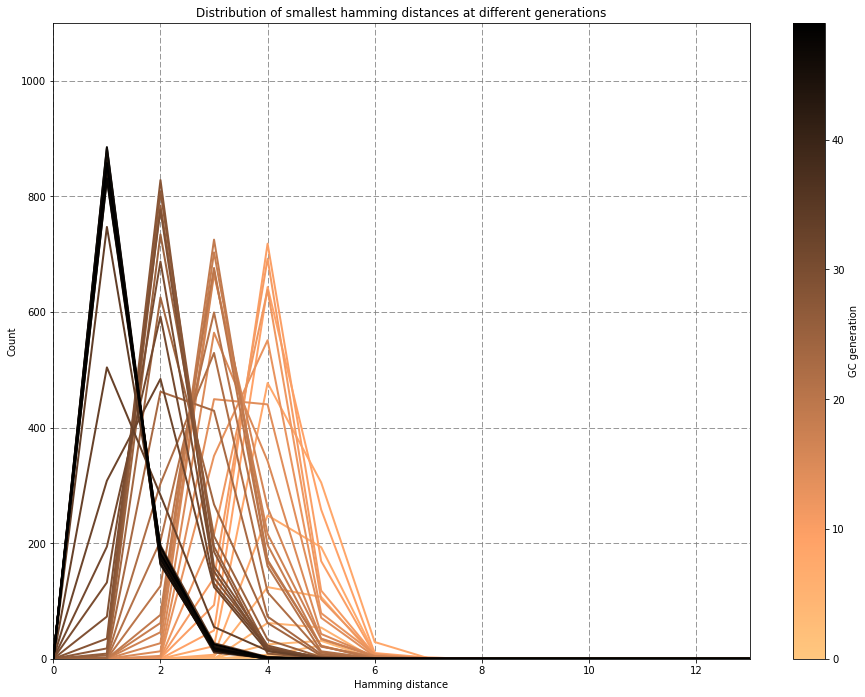

In [761]:
plot_LineSegements(runstats[0][1][:-1], [r[0] for r in runstats], ylim=[0, 1100],
                   label_str='GC generation', linewidth=2.0, linestyle='solid', cm='copper_r', outOS=None)